In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.fftpack import * 

2021.07.02

进行谱分析的脚本，读入数据，设置一个余弦平方的idctn的转换函数，之后应用到数据上，进行数字滤波

single_ 略微进行修改,进行一个时次的计算（而不是multvar的整个时次）

用作一张图的测试性的idctn（先平均再idctn，而不是将idctn之后的序列进行平均）

2021.07.13

稍微进行修改，考虑进行一个局地的分析，需要对经纬度范围进行选取，然后修改区域内的长宽

读入数据,根据不同的需求有三部分
- 为了进行谱分析制作的KE（高层的平均值）
- 此前从diag_daily 中选取的湿度变量
- remains：正在制作的湿度变量
- hgt

处理到最后执行分析的变量是 mean_test

## 数据读入

- 1.使用的高层的KE

In [ ]:
ke_sum = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['rcm'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['vr'] = ds_ke_sum['vertical integration Ke']

In [ ]:
# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
ke_sum_rmnan = {}
ke_sum_rmnan['vr']  = ke_sum['vr'] = ke_sum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
ke_sum_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [ ]:
mean_test = ke_sum_rmnan['vr'].mean('Time')

- 2.使用低层的露点温度

因为值太大，修改读取方法，先进行读取，再从读取的值中进行na的插值工作

In [ ]:
hum = {}
hum_rmnan = {}

dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily_selected/hum/"
ds_ke_sum = xr.open_dataset(dir_in + "1998_VR_diag.nc")
hum['vr'] = ds_ke_sum['dewpoint_850hPa']
hum_rmnan['vr'] = hum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily_selected/hum/"
ds_ke_sum = xr.open_dataset(dir_in + "1998_RCM_diag.nc")
hum['rcm'] = ds_ke_sum['dewpoint_850hPa']
hum_rmnan['rcm'] = hum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

- 3.使用500hPa 位势高度

In [ ]:
hum = {} # 放置提取出的变量
hum_rmnan = {} # 防止进行插值之后处理的变量

dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily_selected/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "hgt_VR_98-17.nc")
hum['vr'] = ds_ke_sum['height_500hPa']
hum_rmnan['vr'] = hum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily_selected/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "hgt_RCM_98-17.nc")
hum['rcm'] = ds_ke_sum['height_500hPa']
hum_rmnan['rcm'] = hum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "merge_hgt_daily.nc")
hum['era5i'] = ds_ke_sum['hgt'].sel({'level':500}).drop('level')
hum_rmnan['era5i'] = hum['era5i'].interpolate_na(dim = 'lon', method = 'cubic', max_gap = None, fill_value="extrapolate")

- ~~使用shum  弃用：因为过多的缺测值的存在，不考虑使用自己计算出的，而是模式直接生成的shum~~

In [ ]:
hum = {} # 放置提取出的变量
hum_rmnan = {} # 防止进行插值之后处理的变量
dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/hum_theta_daily_vi/"
ds_ke_sum = xr.open_mfdataset(dir_in + "*_VR_hum_theta_daily_vi.nc", parallel=True)
hum['vr'] = ds_ke_sum['qv'].sel(plevels=500)
hum_rmnan['vr'] = hum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/hum_theta_daily_vi/"
ds_ke_sum = xr.open_mfdataset(dir_in + "*_RCM_hum_theta_daily_vi.nc", parallel=True)
hum['rcm'] = ds_ke_sum['qv'].sel(plevels=500)
hum_rmnan['rcm'] = hum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/shum_98-17_daily/"
ds_ke_sum = xr.open_dataset(dir_in + "merge_shum_daily.nc")
hum['era5i'] = ds_ke_sum['shum'].sel({'level':500}).drop('level')
hum_rmnan['era5i'] = hum['era5i'].interpolate_na(dim = 'lon', method = 'cubic', max_gap = None, fill_value="extrapolate")

- 使用可降水量

In [2]:
hum = {} # 放置提取出的变量
hum_rmnan = {} # 防止进行插值之后处理的变量
dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily/"
ds_ke_sum = xr.open_mfdataset(dir_in + "*_VR_diag.nc", parallel=True)
hum['vr'] = ds_ke_sum['precipw']
hum_rmnan['vr'] = hum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily/"
ds_ke_sum = xr.open_mfdataset(dir_in + "*_RCM_diag.nc", parallel=True)
hum['rcm'] = ds_ke_sum['precipw']
hum_rmnan['rcm'] = hum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

# ERA5I daily的可降水量暂时没有处理出来，先使用RCM替代
hum_rmnan['era5i'] = hum_rmnan['rcm']

## 合并到var_3d var_2d（时间平均上）

In [3]:
# 修改ERA5I coords
hum_rmnan['era5i'] = hum_rmnan['era5i'].rename({"time":"Time", "lon":"longitude", "lat":"latitude"})
hum_rmnan['era5i']._coords = hum_rmnan['vr']._coords

ValueError: cannot rename 'time' because it is not a variable or dimension in this dataset

In [41]:
time_idx = pd.date_range(start = "1998-08-01", end = "1998-08-31",freq='d')
# time_idx_era5i = pd.date_range(start = "1998-06-01-10:30", end = "1998-06-30-10:30",freq='d')
# 添加小区域 ，选定区域到这个位置上
lat  = hum_rmnan['vr'].latitude
lon  = hum_rmnan['vr'].longitude
Time = hum_rmnan['vr'].Time
time_sel = time_idx
lat_sel = lat[( lat >= 15 ) & ( lat<=55 )]
lon_sel = lon[( lon >= 100 ) & ( lon<=140 )]
# time_idx
# hum_rmnan['vr'].sel(Time=time_idx)

# mean_test = hum_rmnan['rcm'].mean('Time')
var_3d = {}
sel_dict = {"Time":time_idx, "longitude":lon_sel, "latitude":lat_sel}
var_3d['vr']  = hum_rmnan['vr'].sel(sel_dict)#.sel({'Time':hum_rmnan['vr'].Time.dt.month.isin([6])})
var_3d['rcm'] = hum_rmnan['rcm'].sel(sel_dict)#.sel({'Time':hum_rmnan['rcm'].Time.dt.month.isin([6])})
# 换到相同的时间坐标上
var_3d['era5i'] = hum_rmnan['era5i'].sel(sel_dict)#.sel({'time':hum_rmnan['era5i'].time.dt.month.isin([6])})

var_2d = {}
var_2d['vr']  = var_3d['vr'].mean("Time")
var_2d['rcm'] = var_3d['rcm'].mean("Time")
var_2d['era5i'] = var_3d['era5i'].mean("Time")

计算波数等绘图变量，构造cosine squared的滤波窗口

暂时修改为3D的情况，先将多个时次进行dctn之后，乘上权重，再对idctn结果进行平均，到一张图上

In [42]:
ntime = var_3d['vr'].shape[0]
nlat = var_3d['vr'].shape[1]
nlon = var_3d['vr'].shape[2]
# lat_length = 5017 * 1e3 # m
# lon_length = 7061 * 1e3 # m
lat_length = 4445. * 1e3 # m
lon_length = 3829. * 1e3 # m
dlat = lat_length / nlat
dlon  = lon_length / nlon
all_length = np.sqrt(lat_length**2 + lon_length**2)
all_n      = np.sqrt(nlat**2 + nlon **2)

# 计算1000km 和 500km对应的无量纲波数（区域内）
k_domain_1000 = all_n / (1000*1e3 / np.sqrt(dlat**2 + dlon**2)) 
k_domain_500  = all_n / (500*1e3 / np.sqrt(dlat**2 + dlon**2))

# 进行计算的函数
def k_domain_count(x, all_n=all_n, dlat=dlat, dlon=dlon):
    '输入变量x 单位km'
    k_domain_res  = all_n / (x*1e3 / np.sqrt(dlat**2 + dlon**2))
    return k_domain_res

In [43]:
def weight_cosine_squared(x, k_s, k_e):
    '计算余弦平方的权重，低通滤波'
    '计算余弦平方的权重，暂时修改为高通滤波滤波'
    import numpy as np
    res = np.array(x)
    if (x<=k_s):
        res = 1
    if (x>=k_e):
        res = 0
    if ((x>=k_s) & (x<=k_e)):
        res = np.cos(np.pi*(x-k_s) / (2*(k_e - k_s)))**2
    return res

def weight_cosine_squared_band(x, k_s, k_e, k_inter):
    '计算余弦平方的权重，带通滤波'
    'k_inter 为进行缓冲的k的大小'
    import numpy as np
    res = 1.
    k_center = (k_s + k_e) / 2.
    if (x<=k_s):
        res = 0
    if (x>=k_e):
        res = 0
    if ((x>=k_center+k_inter) & (x<=k_e)):
        res = np.cos(np.pi*(x-(k_center+k_inter)) / (2*(k_e - (k_center + k_inter))))**2
        # res = 1.3#np.cos(np.pi*(x-(k_center+k_inter)) / (2*(k_e - (k_center + k_inter))))**2
    if ((x<=k_center-k_inter) & (x>=k_s)):
        res = np.cos(np.pi*(x-(k_center - k_inter)) / (2*((k_center-k_inter) - k_s)))**2
        # res = 1.2#np.cos(np.pi*(x-(k_center - k_inter)) / (2*(k_e - (k_center-k_inter))))**2
    return res

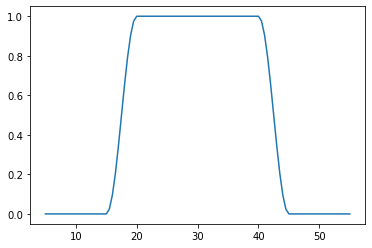

In [8]:
# 检查转换函数
# test_weight_x = np.linspace(k_domain_1000-10, k_domain_500+10,101)
test_weight_x = np.linspace(5,55,101)
test_weight_y = np.empty(shape = test_weight_x.shape)
for i,xi in enumerate(test_weight_x):
    # test_weight_y[i] = weight_cosine_squared_band(xi, k_domain_1000, k_domain_500, 2)
    test_weight_y[i] = weight_cosine_squared_band(xi, 15, 45, 10)
plt.plot(test_weight_x, test_weight_y)

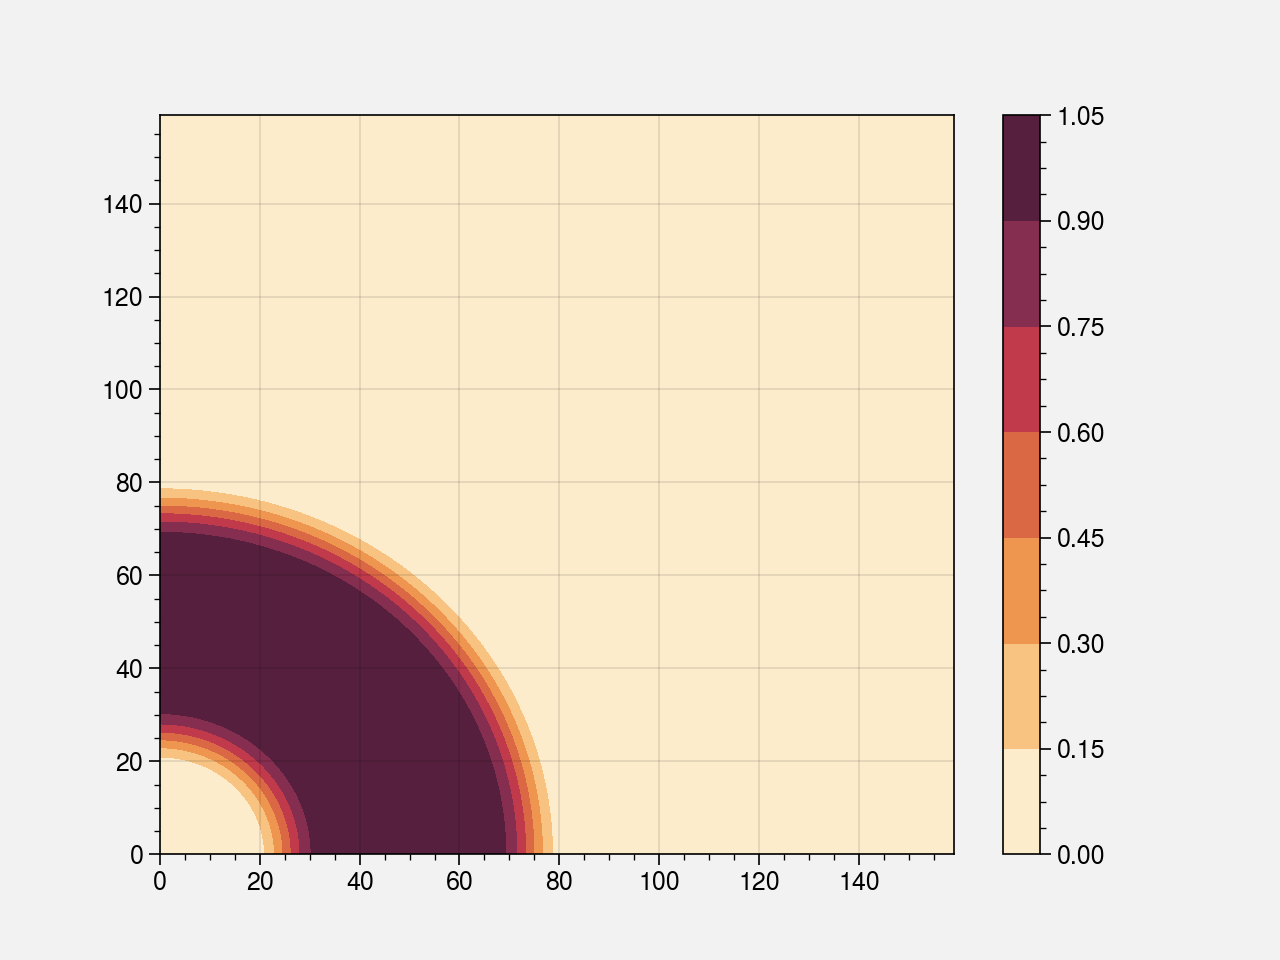

In [61]:
# 构造weight array，以便对DCT结果使用
weight_array_cosine = np.empty(var_3d['vr'].shape)
# DCT 频率是如何对应的？remains
# freq_lat = fftfreq(nlat,1./nlat)
# freq_lon = fftfreq(nlon,1./nlon)
freq_lat = range(0, nlat)
freq_lon = range(0, nlon)
# for t in range(0, ntime):
for i in range(0,nlat):
    for j in range(0,nlon):
        k_domain_2d = np.sqrt((freq_lat[i])**2 + (freq_lon[j])**2)
        # weight_array_cosine[:, i, j] = weight_cosine_squared(k_domain_2d, k_domain_count(2000), k_domain_count(1800))
        # weight_array_cosine[:, i, j] = weight_cosine_squared(k_domain_2d, k_domain_count(2000), k_domain_count(500))
        weight_array_cosine[:,i,j] = weight_cosine_squared_band(k_domain_2d, k_domain_count(500), k_domain_count(100), 16)

# 检查权重matrix效果
plt.contourf(weight_array_cosine[0,:,:])
plt.colorbar()

进行DCT & IDCT

暂时修改为对3D数据使用

进行DCT之后再进行平均

In [55]:
dctn_3d = {}
dctn_3d_weighted = {}
dctn_3d['vr']           = dctn(var_3d['vr'].values, type=2,axes=[1,2], norm = 'ortho')
dctn_3d_weighted['vr']  = dctn_3d['vr'].copy() * weight_array_cosine

dctn_3d['rcm']           = dctn(var_3d['rcm'].values, type=2,axes=[1,2], norm = 'ortho')
dctn_3d_weighted['rcm']  = dctn_3d['rcm'].copy() * weight_array_cosine

dctn_3d['era5i']           = dctn(var_3d['era5i'].values, type=2,axes=[1,2], norm = 'ortho')
dctn_3d_weighted['era5i']  = dctn_3d['era5i'].copy() * weight_array_cosine

idctn_3d  = {}
idctn_3d['vr'] = idctn(dctn_3d_weighted['vr'], type=2,axes=[1,2], norm = 'ortho')
idctn_3d['rcm'] = idctn(dctn_3d_weighted['rcm'], type=2,axes=[1,2], norm = 'ortho')
idctn_3d['era5i'] = idctn(dctn_3d_weighted['era5i'], type=2,axes=[1,2], norm = 'ortho')

# 再在时间上进行平均
idctn_2d  = {}
idctn_2d['vr'] = idctn_3d['vr'].mean(axis=0)
idctn_2d['rcm'] = idctn_3d['rcm'].mean(axis=0)
idctn_2d['era5i'] = idctn_3d['era5i'].mean(axis=0)

# 平均态的做差，找到剩余的波动
idctn_diff = {}
idctn_diff['vr']  = var_2d['vr'].values - idctn_2d['vr']
idctn_diff['rcm'] = var_2d['rcm'].values - idctn_2d['rcm']
idctn_diff['era5i'] = var_2d['era5i'].values - idctn_2d['era5i']


先进行平均场计算，再进行DCT

In [62]:
dctn_3d = {}
dctn_3d_weighted = {}
dctn_3d['vr']           = dctn(var_2d['vr'].values, type=2,axes=[0,1], norm = 'ortho')
dctn_3d_weighted['vr']  = dctn_3d['vr'].copy() * weight_array_cosine[0,:,:]

dctn_3d['rcm']           = dctn(var_2d['rcm'].values, type=2,axes=[0,1], norm = 'ortho')
dctn_3d_weighted['rcm']  = dctn_3d['rcm'].copy() * weight_array_cosine[0,:,:]

dctn_3d['era5i']           = dctn(var_2d['era5i'].values, type=2,axes=[0,1], norm = 'ortho')
dctn_3d_weighted['era5i']  = dctn_3d['era5i'].copy() * weight_array_cosine[0,:,:]

idctn_3d  = {}
idctn_3d['vr'] = idctn(dctn_3d_weighted['vr'], type=2,axes=[0,1], norm = 'ortho')
idctn_3d['rcm'] = idctn(dctn_3d_weighted['rcm'], type=2,axes=[0,1], norm = 'ortho')
idctn_3d['era5i'] = idctn(dctn_3d_weighted['era5i'], type=2,axes=[0,1], norm = 'ortho')

# 再在时间上进行平均
idctn_2d  = {}
idctn_2d['vr'] = idctn_3d['vr']#.mean(axis=0)
idctn_2d['rcm'] = idctn_3d['rcm']#.mean(axis=0)
idctn_2d['era5i'] = idctn_3d['era5i']#.mean(axis=0)

# 平均态的做差，找到剩余的波动
idctn_diff = {}
idctn_diff['vr']  = var_2d['vr'].values - idctn_2d['vr']
idctn_diff['rcm'] = var_2d['rcm'].values - idctn_2d['rcm']
idctn_diff['era5i'] = var_2d['era5i'].values - idctn_2d['era5i']


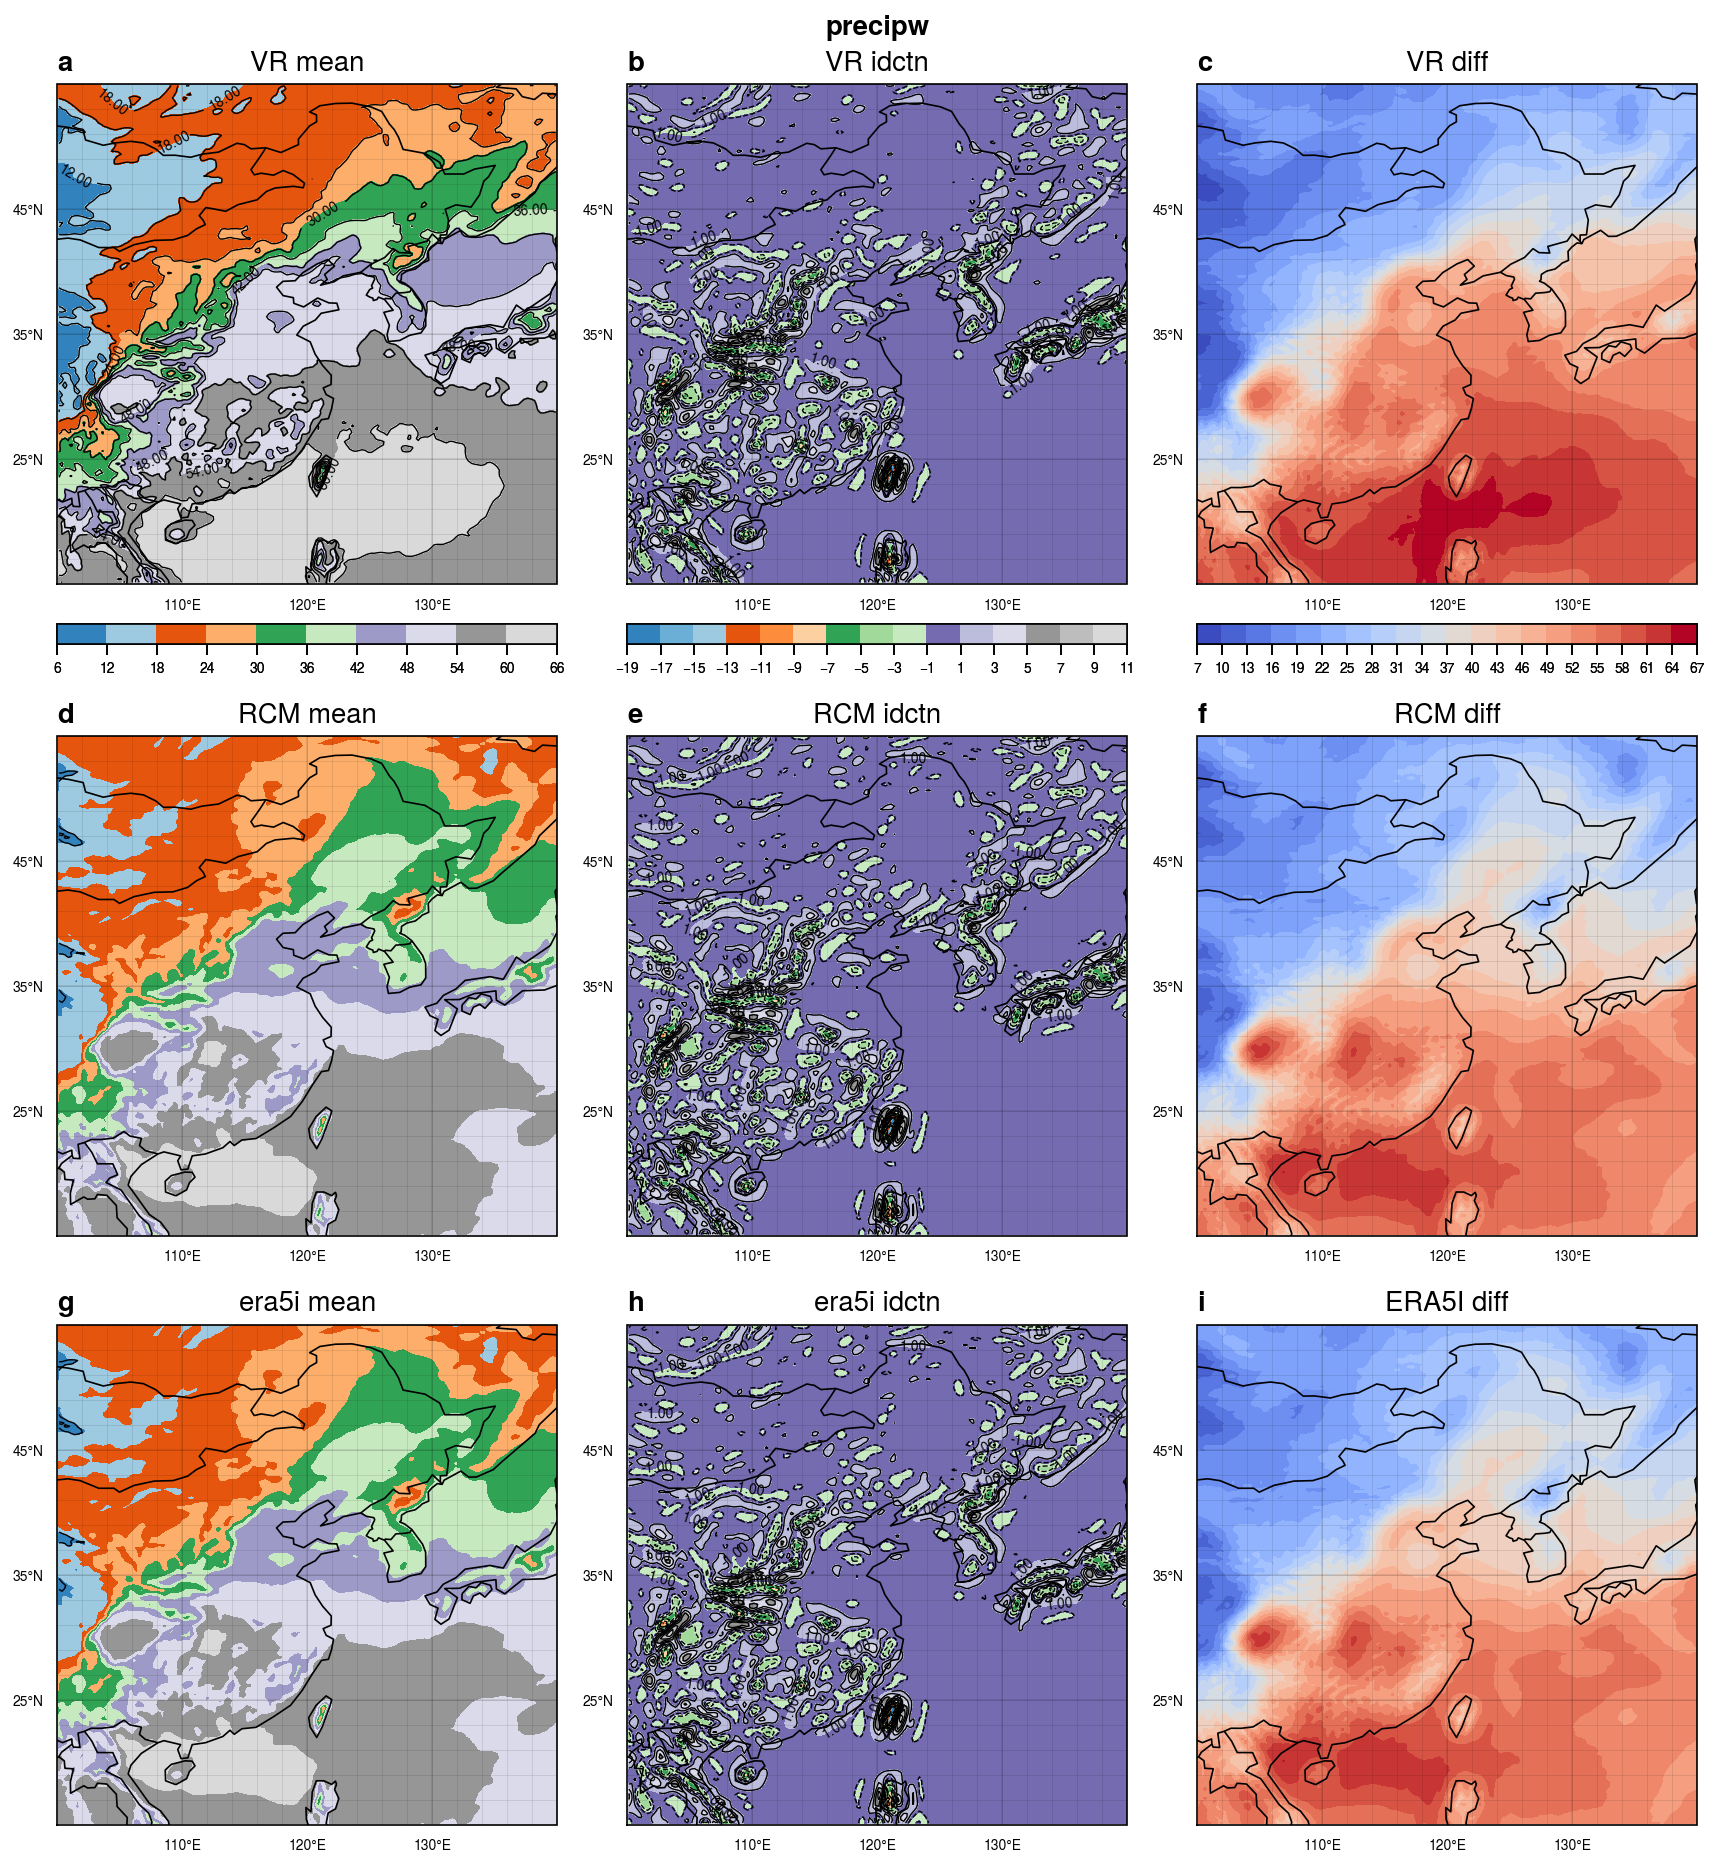

In [63]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

lon = var_3d['vr'].longitude.values
lat = var_3d['vr'].latitude.values

#----- create plot -----
fig, axs = plot.subplots(ncols=3,nrows=3, proj=('cyl'))
m_contour_list = []
#-----VR pannel setting-----
# 平均态
axs[0].format(title='VR mean')
# mean_ticks = np.linspace(5600,5900, 16)
mean_ticks = np.linspace(int(var_2d['vr'].min()) - 1., int(var_2d['vr'].max())+1,11)

m_mean = axs[0].contourf(lon, lat, var_2d['vr'].values,\
levels=mean_ticks,cmap='tab20c')
# 添加contour，在后续进行
m_contour  = axs[0].contour(lon, lat, var_2d['vr'].values,\
levels=mean_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# IDCTN的时间平均
axs[1].format(title='VR idctn')
idctn_ticks = np.linspace(int(idctn_2d['vr'].min()) - 1, int(idctn_2d['vr'].max())+1,16)
# idctn_ticks = np.linspace(-4., 4., 21)
# idctn_ticks = np.linspace(5600,5900,16)

m_idctn = axs[1].contourf(lon, lat, idctn_2d['vr'],\
levels=idctn_ticks,cmap='tab20c')
# 添加contour
m_contour  = axs[1].contour(lon, lat, idctn_2d['vr'],\
levels=idctn_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# 做差结果
axs[2].format(title='VR diff')
diff_ticks = np.linspace(int(idctn_diff['vr'].min()) - 1, int(idctn_diff['vr'].max())+1,21)
# diff_ticks = np.linspace(5400., 5900.,(5900-5400)//50 + 1)
# diff_ticks = np.linspace(-10., 10.,21)
# diff_ticks = np.linspace(-5., 5.,21)
# diff_ticks = np.linspace(-2., 2.,21)

m_idctn_diff = axs[2].contourf(lon, lat, idctn_diff['vr'],\
levels=diff_ticks,cmap='coolwarm')

#-----RCM pannel setting-----
# 平均态
axs[3].format(title='RCM mean')
# mean_ticks = np.arange(240,300,5.)
# mean_ticks = np.linspace(var_2d['rcm'].min(), var_2d['rcm'].max(),11)

m_mean = axs[3].contourf(lon, lat, var_2d['rcm'].values,\
levels=mean_ticks,cmap='tab20c')
m_contour  = axs[3].contour(lon, lat, var_2d['rcm'].values,\
levels=idctn_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# dctn平均
axs[4].format(title='RCM idctn')
# idctn_ticks = np.linspace(idctn['rcm'].min(), idctn['rcm'].max(),11)
# idctn_ticks = np.linspace(-10., 10., 21)

m_idctn = axs[4].contourf(lon, lat, idctn_2d['rcm'],\
levels=idctn_ticks,cmap='tab20c')
m_contour  = axs[4].contour(lon, lat, idctn_2d['rcm'],\
levels=idctn_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# 做差结果
axs[5].format(title='RCM diff')
# diff_ticks = np.linspace(idctn_diff.min(), idctn_diff.max(),21)
# diff_ticks = np.linspace(-5., 5.,21)
# diff_ticks = np.linspace(-10., 10.,21)

m_idctn_diff = axs[5].contourf(lon, lat, idctn_diff['rcm'],\
levels=diff_ticks,cmap='coolwarm')

# -----ERA5I pannel -----
# 平均态
axs[6].format(title='era5i mean')
# mean_ticks = np.arange(240,300,5.)
# mean_ticks = np.linspace(var_2d['rcm'].min(), var_2d['rcm'].max(),11)

m_mean = axs[6].contourf(lon, lat, var_2d['era5i'].values,\
levels=mean_ticks,cmap='tab20c')
m_contour  = axs[6].contour(lon, lat, var_2d['era5i'].values,\
levels=idctn_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# dctn平均
axs[7].format(title='era5i idctn')
# idctn_ticks = np.linspace(idctn['rcm'].min(), idctn['rcm'].max(),11)
# idctn_ticks = np.linspace(-10., 10., 21)

m_idctn = axs[7].contourf(lon, lat, idctn_2d['era5i'],\
levels=idctn_ticks,cmap='tab20c')
m_contour  = axs[7].contour(lon, lat, idctn_2d['era5i'],\
levels=idctn_ticks,color='k',
linewidth = .5)
m_contour_list.append(m_contour)

# 做差结果
axs[8].format(title='ERA5I diff')
# diff_ticks = np.linspace(idctn_diff.min(), idctn_diff.max(),21)
# diff_ticks = np.linspace(-5., 5.,21)
# diff_ticks = np.linspace(-10., 10.,21)

m_idctn_diff = axs[8].contourf(lon, lat, idctn_diff['era5i'],\
levels=diff_ticks,cmap='coolwarm')


# ----- format setting -----
axs.format(
abc=True,
# lonlim=(70, 140), latlim=(15, 55), coast=True,
lonlim=(100, 140), latlim=(15, 55), coast=True,
#-----GEO axis-----
borders = True,
labels = True,
gridlabelsize = 5,
gridminor = True,
# ticklen = 10,
# borderslinewidth=.5,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,150,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="precipw",
)
#----- add contour tick labels -----
for i,axs_ind in enumerate(m_contour_list):
    # axs[i].clabel(axs_ind, inline=True, fontsize=5, colors = 'k', fmt='%4.0f',use_clabeltext=True, inline_spacing=1)
    axs[i].clabel(axs_ind, inline=True, fontsize=5, colors = 'k', fmt='%.2f',use_clabeltext=True, inline_spacing=1)

#----- add color bar-----
# fig.colorbar(m_overlay, loc='b', cmap=cmap, width=0.1)

# fig.colorbar(m_mean, loc='b', width=0.1,
# ticklabelsize=5,ticks=mean_ticks)

axs[0].colorbar(m_mean, loc='b', width=0.1,
ticklabelsize=5,ticks=mean_ticks)

axs[1].colorbar(m_idctn, loc='b', width=0.1,
ticklabelsize=5,ticks=idctn_ticks)

axs[2].colorbar(m_idctn_diff, loc='b',width=0.1,
ticklabelsize=5,ticks=diff_ticks)

#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/precipw_band_199808.png', dpi=300, facecolor= "white")